# Example usage

This notebook will show how to get started with the `databallpy` package. The package is build around the `Match` class. All information about match is saved in this class. Amoung others, the class has attributes `tracking_data`, `event_data`, `home_players`, `away_score`, and `home_formation`. For more information on the `Match` class see our [documentation](https://databallpy.readthedocs.io/en/latest/autoapi/databallpy/index.html "databallpy documentation"). 

To use obtain a `Match` using `databallpy` in a project, run the following code:

In [29]:
import sys
!{sys.executable} -m pip install --upgrade pip --quiet --no-warn-script-location
!{sys.executable} -m pip install databallpy==0.2.0a1 --quiet --no-warn-script-location

In [30]:
import databallpy
print(databallpy.__version__)

0.2.0a1


In [31]:
# obtain a match object
from databallpy.match import get_match, get_open_match

# get match from private data
# match = get_match(
#     tracking_data_loc="../data/test tracking data.dat",
#     tracking_metadata_loc="../data/test metadata.xml",
#     tracking_data_provider="tracab",
#     event_data_loc="../data/test f24.xml",
#     event_metadata_loc="../data/test f7.xml",
#     event_data_provider="opta"   
# )

# or use open metric data
match = get_open_match()

Writing lines to dataframe:


100%|██████████| 143761/143761 [00:19<00:00, 7292.27it/s]


In [32]:
match.tracking_data.iloc[365:375, :10]

,timestamp,ball_x,ball_y,ball_z,ball_status,ball_posession,home_1_x,home_1_y,home_2_x,home_2_y
365,366,0.05040,-0.87108,NaN,alive,None,36.01710,1.02952,14.39025,-20.88280
366,367,0.03360,-0.87176,NaN,alive,None,36.04230,1.00640,14.36190,-20.90864
367,368,0.01680,-0.87244,NaN,alive,None,36.06645,0.98736,14.33355,-20.93992
368,369,0.00000,-0.87380,NaN,alive,None,36.09060,0.96492,14.30625,-20.97460
369,370,-0.01575,-0.87448,NaN,alive,None,36.11895,0.93568,14.27895,-21.02084
370,371,-0.03255,-0.87516,NaN,alive,None,36.14520,0.91052,14.24955,-21.05416
371,372,-0.04935,-0.87584,NaN,alive,None,36.17250,0.88400,14.22015,-21.09088
372,373,-0.06615,-0.87652,NaN,alive,None,36.20085,0.85816,14.19285,-21.12352
373,374,-0.08190,-0.87788,NaN,alive,None,36.23235,0.83776,14.16870,-21.16908
374,375,-0.09870,-0.87856,NaN,alive,None,36.26595,0.81328,14.14560,-21.21124


In [33]:
match.event_data.head(10)

,event_id,type_id,event,period_id,minutes,seconds,player_id,player_name,team_id,outcome,start_x,start_y,to_player_id,to_player_name,end_x,end_y,td_frame,datetime
0,1,5,set piece,1,0,14.44,3577,Player 10,FIFATMA,NaN,NaN,NaN,NaN,None,NaN,NaN,361,2019-02-21 03:30:21.400000+00:00
1,2,1,pass,1,0,14.44,3577,Player 10,FIFATMA,NaN,0.13125,-0.86700,3574.0,Player 7,-0.14280,-0.88060,361,2019-02-21 03:30:21.400000+00:00
2,3,10,carry,1,0,15.08,3574,Player 7,FIFATMA,NaN,-0.14280,-0.88060,NaN,None,-0.31500,-1.02000,377,2019-02-21 03:30:22.040000+00:00
3,4,1,pass,1,0,15.36,3574,Player 7,FIFATMA,NaN,-0.31500,-1.02000,3575.0,Player 8,14.04165,9.14532,384,2019-02-21 03:30:22.320000+00:00
4,5,10,carry,1,0,17.04,3575,Player 8,FIFATMA,NaN,14.04165,9.14532,NaN,None,17.83530,6.60076,426,2019-02-21 03:30:24+00:00
5,6,1,pass,1,0,18.60,3575,Player 8,FIFATMA,NaN,17.83530,6.60076,3569.0,Player 2,32.13210,-6.92172,465,2019-02-21 03:30:25.560000+00:00
6,7,10,carry,1,0,20.28,3569,Player 2,FIFATMA,NaN,32.13210,-6.92172,NaN,None,32.47545,-4.81304,507,2019-02-21 03:30:27.240000+00:00
7,8,1,pass,1,0,21.20,3569,Player 2,FIFATMA,NaN,32.47545,-4.81304,3570.0,Player 3,31.40130,21.43496,530,2019-02-21 03:30:28.160000+00:00
8,9,10,carry,1,0,23.20,3570,Player 3,FIFATMA,NaN,31.40130,21.43496,NaN,None,31.24380,21.75864,580,2019-02-21 03:30:30.160000+00:00
9,10,1,pass,1,0,23.92,3570,Player 3,FIFATMA,NaN,31.24380,21.75864,3571.0,Player 4,19.00605,32.68012,598,2019-02-21 03:30:30.880000+00:00


In [34]:
match.home_players

,id,full_name,formation_place,position,starter,shirt_num
0,3578,Player 11,0,Goalkeeper,True,11
1,3568,Player 1,1,Right Back,True,1
2,3569,Player 2,1,Right Center Back (4),True,2
3,3570,Player 3,1,Left Center Back (4),True,3
4,3571,Player 4,1,Left Back,True,4
5,3572,Player 5,2,"Attacking Right Midfielder (4,5)",True,5
6,3573,Player 6,2,Defensive Right Center Midfielder (5),True,6
7,3574,Player 7,2,Attacking Center Midfielder,True,7
8,3575,Player 8,2,Defensive Left Center Midfielder (5),True,8
9,3576,Player 9,2,"Attacking Left Midfielder (4,5)",True,9


# Save Match Clip

A second functionality is in saving match clips of the event data. To save a match clip, run the following code:

In [35]:
from databallpy.visualize import save_match_clip

# saving match clip from the index 1065 to 1165, with a frame rate of 25 fps (4 seconds of the match).
save_match_clip(match, 1065,1165, save_folder="example_data", title="example")

Making match clip...


100%|██████████| 101/101 [00:01<00:00, 54.80it/s]


In [36]:
from IPython.display import Video
Video("example_data/example.mp4")

# Plot events

Also, events can be plotted. You can specify the event, the outcome, the player, and the team. For instance, if you want all passes of the home team plotted, colored by the outcome of the pass you can use the following code:

Found 20 matching events


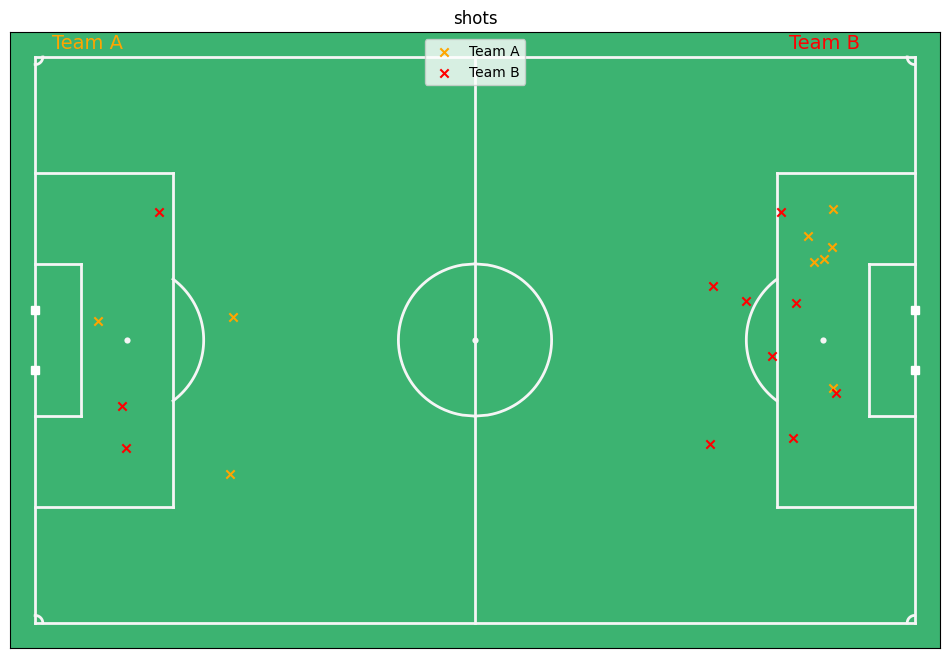

In [39]:
from databallpy.visualize import plot_events
import matplotlib.pyplot as plt

fig, ax = plot_events(match, events=["shot"], color_by_col="team_id", title="shots")
plt.show()

# Synchronise tracking and event data

Lastly, you can also smartly synchronise the tracking and event data. Synchronisation of tracking and event data is usefull when making, for example, expected goal models. Often the event and tracking data do not perfectly align on match time alone. Our model uses the Needleman-Wunsch algorithm proposed by [this](https://kwiatkowski.io/sync.soccer) article to synchronize the data.

To synchronise the tracking and event data run:

In [ ]:
match.synchronize_event_and_tracking_data()